# Tutorial 1: Basic Connectivity Patterns

This tutorial introduces the fundamental connectivity patterns in `braintools.conn`. You'll learn how to create basic network topologies, understand connection results, and work with weights and delays.

---

## 1. Introduction to Connectivity <a name="introduction"></a>

Neural networks are defined not just by their neurons, but by how those neurons are connected. The `braintools.conn` module provides a comprehensive system for generating biologically-plausible connectivity patterns.

### Why Connectivity Matters

- **Network Dynamics**: Connection patterns determine how information flows through neural populations
- **Computational Properties**: Different topologies enable different computations
- **Biological Realism**: Real neural circuits exhibit specific connectivity motifs
- **Efficiency**: Sparse connectivity reduces computational cost while maintaining function

Let's start by importing the necessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brainunit as u
from braintools import conn, visualize as vis
from braintools.init import Constant, Normal, Uniform, LogNormal

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 10

print("✓ Imports successful")

✓ Imports successful


---

## 2. Understanding ConnectionResult <a name="connectionresult"></a>

All connectivity patterns in `braintools.conn` return a `ConnectionResult` object. This object contains:

- **`pre_indices`**: Array of presynaptic neuron indices
- **`post_indices`**: Array of postsynaptic neuron indices
- **`weights`**: Synaptic weights (optional)
- **`delays`**: Synaptic delays (optional)
- **`metadata`**: Additional information about the connectivity pattern

Let's create a simple connection and examine its structure:

In [2]:
# Create a simple random connectivity
simple_conn = conn.Random(prob=0.1, seed=42)
result = simple_conn(pre_size=10, post_size=10)

print("ConnectionResult Structure:")
print("=" * 50)
print(f"Number of connections: {len(result.pre_indices)}")
print(f"\nPresynaptic indices (first 10):")
print(result.pre_indices[:10])
print(f"\nPostsynaptic indices (first 10):")
print(result.post_indices[:10])
print(f"\nWeights: {result.weights}")
print(f"Delays: {result.delays}")
print(f"\nMetadata:")
for key, value in result.metadata.items():
    print(f"  {key}: {value}")

ConnectionResult Structure:
Number of connections: 12

Presynaptic indices (first 10):
[0 1 3 3 4 4 6 6 7 8]

Postsynaptic indices (first 10):
[7 2 2 6 1 7 2 4 5 0]

Weights: None
Delays: None

Metadata:
  pattern: random
  probability: 0.1
  allow_self_connections: False
  weight_initialization: None
  delay_initialization: None


### Connection Density

Let's calculate the connection density (ratio of actual connections to possible connections):

In [3]:
def calculate_density(result, allow_self_connections=False):
    """Calculate connection density from ConnectionResult."""
    pre_size = result.pre_size if isinstance(result.pre_size, int) else np.prod(result.pre_size)
    post_size = result.post_size if isinstance(result.post_size, int) else np.prod(result.post_size)
    
    max_connections = pre_size * post_size
    if not allow_self_connections and pre_size == post_size:
        max_connections -= pre_size
    
    actual_connections = len(result.pre_indices)
    density = actual_connections / max_connections
    
    return density, actual_connections, max_connections

density, actual, maximum = calculate_density(result)
print(f"Connection density: {density:.1%}")
print(f"Actual connections: {actual} / {maximum} possible")
print(f"Expected density (prob=0.1): ~10%")

Connection density: 13.3%
Actual connections: 12 / 90 possible
Expected density (prob=0.1): ~10%


---

## 3. Random Connectivity <a name="random-connectivity"></a>

Random connectivity is the simplest and most fundamental pattern. Each potential connection is made with a fixed probability.

### 3.1 Basic Random Connectivity

The `Random` class (also aliased as `FixedProb`) creates connections with a specified probability:

In [4]:
# Create random connectivity with 10% connection probability
random_conn = conn.Random(prob=0.1, seed=42)
result_random = random_conn(pre_size=100, post_size=100)

print(f"Random Connectivity (prob=0.1)")
print(f"Generated {len(result_random.pre_indices)} connections")

density, actual, maximum = calculate_density(result_random)
print(f"Connection density: {density:.2%}")
print(f"Expected: ~10%")

Random Connectivity (prob=0.1)
Generated 1019 connections
Connection density: 10.29%
Expected: ~10%


### 3.2 Effect of Connection Probability

Let's examine how connection probability affects network density:

In [5]:
# Test different probabilities
probabilities = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
network_size = 100

results_by_prob = {}
for prob in probabilities:
    conn_pattern = conn.Random(prob=prob, seed=42)
    result = conn_pattern(pre_size=network_size, post_size=network_size)
    density, n_conn, _ = calculate_density(result)
    results_by_prob[prob] = (n_conn, density)

# Display results
print("\nConnection Probability vs. Actual Density:")
print("=" * 60)
print(f"{'Probability':<15} {'Connections':<15} {'Density':<15} {'Error'}")
print("=" * 60)
for prob in probabilities:
    n_conn, density = results_by_prob[prob]
    error = abs(density - prob) / prob * 100
    print(f"{prob:<15.2f} {n_conn:<15} {density:<15.4f} {error:>5.1f}%")


Connection Probability vs. Actual Density:
Probability     Connections     Density         Error
0.01            93              0.0094            6.1%
0.05            486             0.0491            1.8%
0.10            1019            0.1029            2.9%
0.20            2021            0.2041            2.1%
0.30            3021            0.3052            1.7%
0.50            5021            0.5072            1.4%


### 3.3 Self-Connections

By default, self-connections (neuron connecting to itself) are disabled. Let's see the difference:

In [6]:
# Without self-connections (default)
conn_no_self = conn.Random(prob=0.2, allow_self_connections=False, seed=42)
result_no_self = conn_no_self(pre_size=50, post_size=50)

# With self-connections
conn_with_self = conn.Random(prob=0.2, allow_self_connections=True, seed=42)
result_with_self = conn_with_self(pre_size=50, post_size=50)

# Check for self-connections
self_conn_mask = result_with_self.pre_indices == result_with_self.post_indices
n_self_connections = np.sum(self_conn_mask)

print("Self-Connections Comparison:")
print("=" * 50)
print(f"Without self-connections: {len(result_no_self.pre_indices)} connections")
print(f"With self-connections:    {len(result_with_self.pre_indices)} connections")
print(f"Number of self-connections: {n_self_connections}")
print(f"Expected self-connections: ~{50 * 0.2:.1f} (50 neurons × 20% prob)")

Self-Connections Comparison:
Without self-connections: 519 connections
With self-connections:    524 connections
Number of self-connections: 9
Expected self-connections: ~10.0 (50 neurons × 20% prob)


---

## 4. Regular Deterministic Patterns <a name="deterministic-patterns"></a>

In addition to random connectivity, `braintools.conn` provides deterministic connectivity patterns.

### 4.1 All-to-All Connectivity

The `AllToAll` pattern connects every presynaptic neuron to every postsynaptic neuron:

In [7]:
# Create all-to-all connectivity
all2all = conn.AllToAll(include_self_connections=False)
result_all2all = all2all(pre_size=10, post_size=10)

print("All-to-All Connectivity:")
print("=" * 50)
print(f"Network size: 10 × 10")
print(f"Connections: {len(result_all2all.pre_indices)}")
print(f"Expected: 10 × 10 - 10 (self) = 90")

density, _, _ = calculate_density(result_all2all)
print(f"Density: {density:.1%}")

All-to-All Connectivity:
Network size: 10 × 10
Connections: 90
Expected: 10 × 10 - 10 (self) = 90
Density: 100.0%


### 4.2 One-to-One Connectivity

The `OneToOne` pattern creates one-to-one mappings, useful for identity mappings or layer-to-layer projections:

In [8]:
# Equal sizes
one2one_equal = conn.OneToOne()
result_equal = one2one_equal(pre_size=10, post_size=10)

print("One-to-One Connectivity (Equal Sizes):")
print("=" * 50)
print(f"Pre size: 10, Post size: 10")
print(f"Connections: {len(result_equal.pre_indices)}")
print(f"Connection pairs (pre → post):")
for i in range(min(5, len(result_equal.pre_indices))):
    print(f"  {result_equal.pre_indices[i]} → {result_equal.post_indices[i]}")

# Different sizes (non-circular)
one2one_diff = conn.OneToOne(circular=False)
result_diff = one2one_diff(pre_size=8, post_size=12)

print(f"\nOne-to-One Connectivity (Different Sizes, Non-Circular):")
print("=" * 50)
print(f"Pre size: 8, Post size: 12")
print(f"Connections: {len(result_diff.pre_indices)}")
print(f"Note: Only first 8 neurons connected (min of 8 and 12)")

# Circular mapping
one2one_circ = conn.OneToOne(circular=True)
result_circ = one2one_circ(pre_size=8, post_size=12)

print(f"\nOne-to-One Connectivity (Different Sizes, Circular):")
print("=" * 50)
print(f"Pre size: 8, Post size: 12")
print(f"Connections: {len(result_circ.pre_indices)}")
print(f"Connection pairs (pre → post):")
for i in range(min(12, len(result_circ.pre_indices))):
    print(f"  {result_circ.pre_indices[i]} → {result_circ.post_indices[i]}")
print(f"Note: Pre indices wrap around using modulo (% 8)")

One-to-One Connectivity (Equal Sizes):
Pre size: 10, Post size: 10
Connections: 10
Connection pairs (pre → post):
  0 → 0
  1 → 1
  2 → 2
  3 → 3
  4 → 4

One-to-One Connectivity (Different Sizes, Non-Circular):
Pre size: 8, Post size: 12
Connections: 8
Note: Only first 8 neurons connected (min of 8 and 12)

One-to-One Connectivity (Different Sizes, Circular):
Pre size: 8, Post size: 12
Connections: 12
Connection pairs (pre → post):
  0 → 0
  1 → 1
  2 → 2
  3 → 3
  4 → 4
  5 → 5
  6 → 6
  7 → 7
  0 → 8
  1 → 9
  2 → 10
  3 → 11
Note: Pre indices wrap around using modulo (% 8)


---

## 5. Working with Weights and Delays <a name="weights-delays"></a>

Synaptic weights and delays are crucial for realistic neural network simulations. `braintools.conn` supports flexible initialization through the `braintools.init` module.

### 5.1 Constant Weights and Delays

The simplest approach uses constant values with physical units:

In [9]:
# Random connectivity with constant weights and delays
conn_const = conn.Random(
    prob=0.1,
    weight=Constant(1.5 * u.nS),  # Synaptic conductance
    delay=Constant(2.0 * u.ms),   # Transmission delay
    seed=42
)

result_const = conn_const(pre_size=50, post_size=50)

print("Connectivity with Constant Weights and Delays:")
print("=" * 50)
print(f"Number of connections: {len(result_const.pre_indices)}")
print(f"\nWeight statistics:")
print(f"  Mean: {np.mean(result_const.weights)}")
print(f"  Std:  {np.std(result_const.weights)}")
print(f"  All weights are identical: {np.all(result_const.weights == result_const.weights[0])}")
print(f"\nDelay statistics:")
print(f"  Mean: {np.mean(result_const.delays)}")
print(f"  Std:  {np.std(result_const.delays)}")

Connectivity with Constant Weights and Delays:
Number of connections: 263

Weight statistics:
  Mean: 1.5 * nsiemens
  Std:  0.0 * nsiemens
  All weights are identical: True

Delay statistics:
  Mean: 2.0 * msecond
  Std:  0.0 * msecond


### 5.2 Stochastic Weight Distributions

More realistic networks use stochastic weight distributions:

#### Normal Distribution

In [10]:
# Normal (Gaussian) distribution
conn_normal = conn.Random(
    prob=0.15,
    weight=Normal(mean=1.0 * u.nS, std=0.2 * u.nS),
    delay=Normal(mean=1.5 * u.ms, std=0.3 * u.ms),
    seed=42
)

result_normal = conn_normal(pre_size=100, post_size=100)

print("Normal Distribution Weights and Delays:")
print("=" * 50)
print(f"Number of connections: {len(result_normal.pre_indices)}")
print(f"\nWeight statistics:")
print(f"  Mean: {np.mean(result_normal.weights):.3f}")
print(f"  Std:  {np.std(result_normal.weights):.3f}")
print(f"  Min:  {np.min(result_normal.weights):.3f}")
print(f"  Max:  {np.max(result_normal.weights):.3f}")
print(f"\nDelay statistics:")
print(f"  Mean: {np.mean(result_normal.delays):.3f}")
print(f"  Std:  {np.std(result_normal.delays):.3f}")
print(f"  Min:  {np.min(result_normal.delays):.3f}")
print(f"  Max:  {np.max(result_normal.delays):.3f}")

Normal Distribution Weights and Delays:
Number of connections: 1515

Weight statistics:
  Mean: 1.004 * nsiemens
  Std:  0.201 * nsiemens
  Min:  0.233 * nsiemens
  Max:  1.675 * nsiemens

Delay statistics:
  Mean: 1.493 * msecond
  Std:  0.291 * msecond
  Min:  0.323 * msecond
  Max:  2.374 * msecond


#### Uniform Distribution

In [12]:
# Uniform distribution
conn_uniform = conn.Random(
    prob=0.15,
    weight=Uniform(low=0.5 * u.nS, high=2.0 * u.nS),
    delay=Uniform(low=0.5 * u.ms, high=3.0 * u.ms),
    seed=42
)

result_uniform = conn_uniform(pre_size=100, post_size=100)

print("Uniform Distribution Weights and Delays:")
print("=" * 50)
print(f"Weight range: [0.5, 2.0] nS")
print(f"  Mean: {np.mean(result_uniform.weights):.3f}")
print(f"  Std:  {np.std(result_uniform.weights):.3f}")
print(f"  Min:  {np.min(result_uniform.weights):.3f}")
print(f"  Max:  {np.max(result_uniform.weights):.3f}")
print(f"\nDelay range: [0.5, 3.0] ms")
print(f"  Mean: {np.mean(result_uniform.delays):.3f}")
print(f"  Std:  {np.std(result_uniform.delays):.3f}")
print(f"  Min:  {np.min(result_uniform.delays):.3f}")
print(f"  Max:  {np.max(result_uniform.delays):.3f}")

Uniform Distribution Weights and Delays:
Weight range: [0.5, 2.0] nS
  Mean: 1.258 * nsiemens
  Std:  0.432 * nsiemens
  Min:  0.500 * nsiemens
  Max:  2.000 * nsiemens

Delay range: [0.5, 3.0] ms
  Mean: 1.749 * msecond
  Std:  0.729 * msecond
  Min:  0.500 * msecond
  Max:  2.998 * msecond


#### Log-Normal Distribution

Log-normal distributions are common in biological synaptic weights:

In [14]:
# Log-normal distribution (common in biological synapses)
conn_lognormal = conn.Random(
    prob=0.15,
    weight=LogNormal(mean=1.0 * u.nS, std=0.5 * u.nS),
    delay=Constant(1.0 * u.ms),
    seed=42
)

result_lognormal = conn_lognormal(pre_size=100, post_size=100)

print("Log-Normal Distribution Weights:")
print("=" * 50)
print(f"Weight statistics:")
print(f"  Mean: {np.mean(result_lognormal.weights):.3f}")
print(f"  Std:  {np.std(result_lognormal.weights):.3f}")
print(f"  Median: {u.math.median(result_lognormal.weights):.3f}")
print(f"  Min:  {np.min(result_lognormal.weights):.3f}")
print(f"  Max:  {np.max(result_lognormal.weights):.3f}")
print(f"\nNote: Log-normal has positive skew (long tail)")

Log-Normal Distribution Weights:
Weight statistics:
  Mean: 1.011 * nsiemens
  Std:  0.507 * nsiemens
  Median: 0.898 * nsiemens
  Min:  0.146 * nsiemens
  Max:  4.410 * nsiemens

Note: Log-normal has positive skew (long tail)


### 5.3 Visualizing Weight Distributions

Let's compare the different weight distributions visually using `braintools.visualize`:

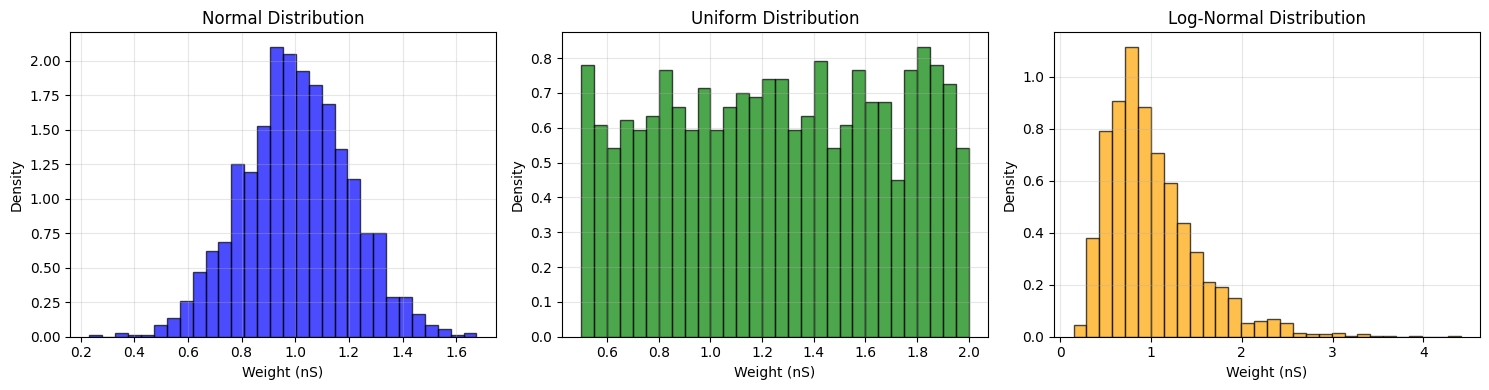


Key Observations:
- Normal: Symmetric around mean
- Uniform: Flat distribution within range
- Log-Normal: Right-skewed with long tail (biologically realistic)


In [19]:
# Extract weight values (remove units for plotting)
weights_normal = u.get_mantissa(result_normal.weights)
weights_uniform = u.get_mantissa(result_uniform.weights)
weights_lognormal = u.get_mantissa(result_lognormal.weights)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot each distribution using vis.distribution_plot
vis.distribution_plot(
    weights_normal,
    bins=30,
    alpha=0.7,
    colors=['blue'],
    edgecolor='black',
    ax=axes[0],
    xlabel='Weight (nS)',
    title='Normal Distribution'
)

vis.distribution_plot(
    weights_uniform,
    bins=30,
    alpha=0.7,
    colors=['green'],
    edgecolor='black',
    ax=axes[1],
    xlabel='Weight (nS)',
    title='Uniform Distribution'
)

vis.distribution_plot(
    weights_lognormal,
    bins=30,
    alpha=0.7,
    colors=['orange'],
    edgecolor='black',
    ax=axes[2],
    xlabel='Weight (nS)',
    title='Log-Normal Distribution'
)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Normal: Symmetric around mean")
print("- Uniform: Flat distribution within range")
print("- Log-Normal: Right-skewed with long tail (biologically realistic)")

---

## 6. Visualizing Connectivity <a name="visualization"></a>

Visualization helps us understand connectivity patterns. We'll use `braintools.visualize` for professional-quality plots.

### 6.1 Connectivity Matrix

A connectivity matrix shows which neurons connect to which. We'll use `vis.connectivity_matrix()`:

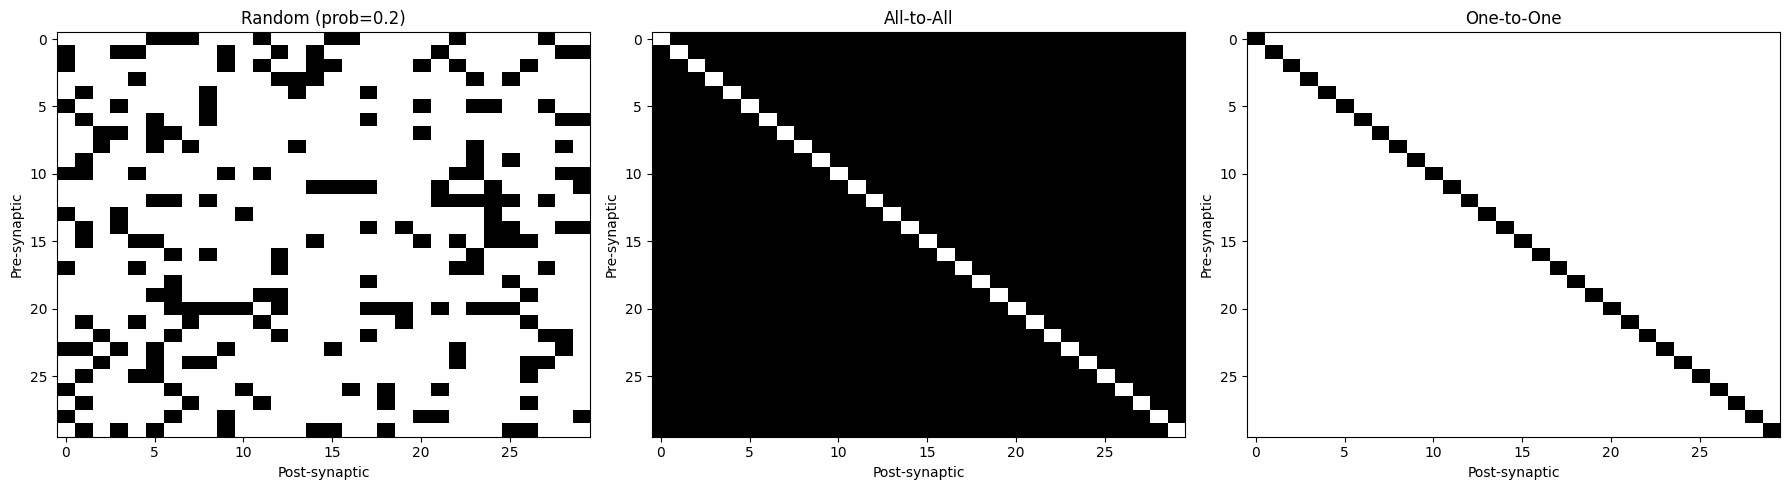

In [20]:
def result_to_matrix(result):
    """Convert ConnectionResult to connectivity matrix."""
    pre_size = result.pre_size if isinstance(result.pre_size, int) else int(np.prod(result.pre_size))
    post_size = result.post_size if isinstance(result.post_size, int) else int(np.prod(result.post_size))
    
    conn_matrix = np.zeros((pre_size, post_size))
    conn_matrix[result.pre_indices, result.post_indices] = 1
    
    return conn_matrix

# Compare different patterns
conn_patterns = [
    (conn.Random(prob=0.2, seed=42), "Random (prob=0.2)"),
    (conn.AllToAll(include_self_connections=False), "All-to-All"),
    (conn.OneToOne(), "One-to-One"),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (conn_pattern, name) in enumerate(conn_patterns):
    result = conn_pattern(pre_size=30, post_size=30)
    conn_mat = result_to_matrix(result)
    
    vis.connectivity_matrix(
        conn_mat,
        cmap='binary',
        center_zero=False,
        show_colorbar=False,
        ax=axes[idx],
        title=name
    )

plt.tight_layout()
plt.show()

### 6.2 Weight Matrix Visualization

When weights are present, we can visualize their distribution in the connectivity matrix:

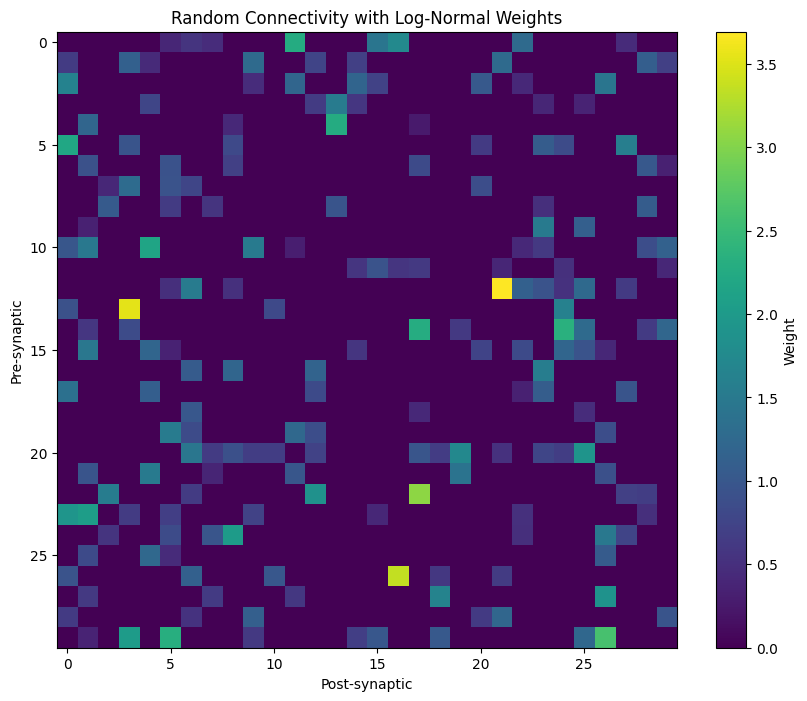

In [21]:
# Create connectivity with weights
conn_weighted = conn.Random(
    prob=0.2,
    weight=LogNormal(mean=1.0 * u.nS, std=0.6 * u.nS),
    seed=42
)
result_weighted = conn_weighted(pre_size=30, post_size=30)

# Create weight matrix
pre_size = 30
post_size = 30
weight_matrix = np.zeros((pre_size, post_size))
weights = u.get_mantissa(result_weighted.weights)
weight_matrix[result_weighted.pre_indices, result_weighted.post_indices] = weights

# Plot using vis.connectivity_matrix
fig, ax = plt.subplots(figsize=(10, 8))
vis.connectivity_matrix(
    weight_matrix,
    cmap='viridis',
    center_zero=False,
    show_colorbar=True,
    ax=ax,
    title='Random Connectivity with Log-Normal Weights'
)
plt.show()

### 6.3 Degree Distribution

The degree distribution shows how many connections each neuron has:

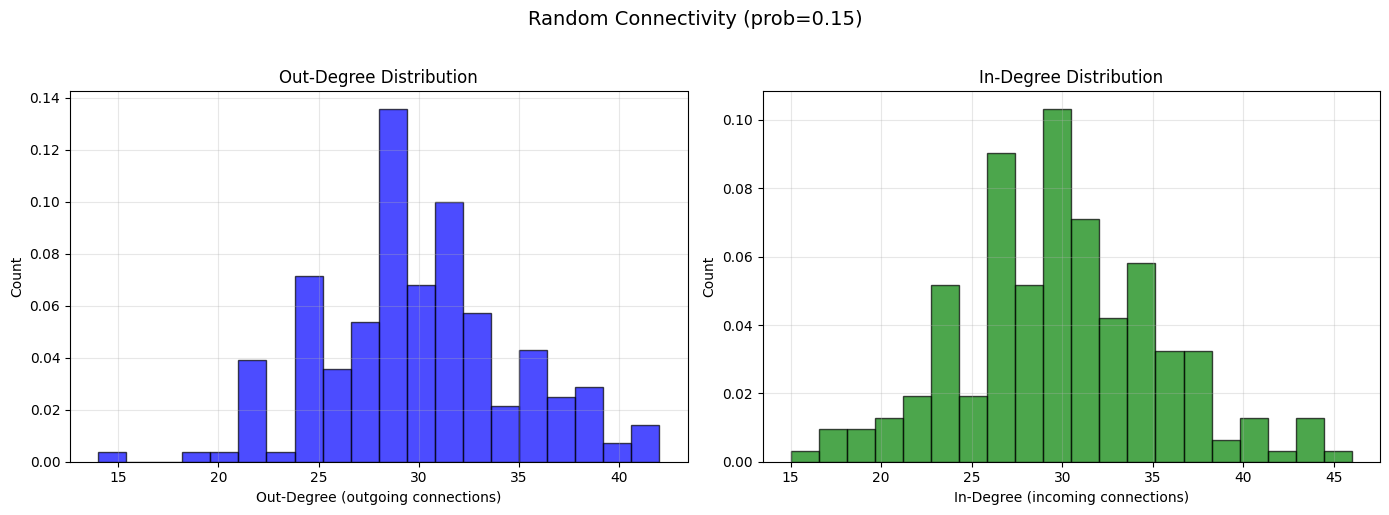

Out-degree: mean=29.86, std=4.74
In-degree:  mean=29.86, std=5.55


In [22]:
# Test with random connectivity
conn_test = conn.Random(prob=0.15, seed=42)
result_test = conn_test(pre_size=200, post_size=200)

# Calculate degrees
pre_size = 200
post_size = 200
out_degree = np.bincount(result_test.pre_indices, minlength=pre_size)
in_degree = np.bincount(result_test.post_indices, minlength=post_size)

# Plot using vis.distribution_plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

vis.distribution_plot(
    out_degree,
    bins=20,
    alpha=0.7,
    colors=['blue'],
    edgecolor='black',
    ax=axes[0],
    xlabel='Out-Degree (outgoing connections)',
    ylabel='Count',
    title='Out-Degree Distribution'
)

vis.distribution_plot(
    in_degree,
    bins=20,
    colors=['green'],
    edgecolor='black',
    alpha=0.7,
    ax=axes[1],
    xlabel='In-Degree (incoming connections)',
    ylabel='Count',
    title='In-Degree Distribution'
)

plt.suptitle('Random Connectivity (prob=0.15)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Out-degree: mean={np.mean(out_degree):.2f}, std={np.std(out_degree):.2f}")
print(f"In-degree:  mean={np.mean(in_degree):.2f}, std={np.std(in_degree):.2f}")

### 6.4 Advanced Visualization: Correlation Matrix

Let's visualize correlations between neurons' connectivity patterns:

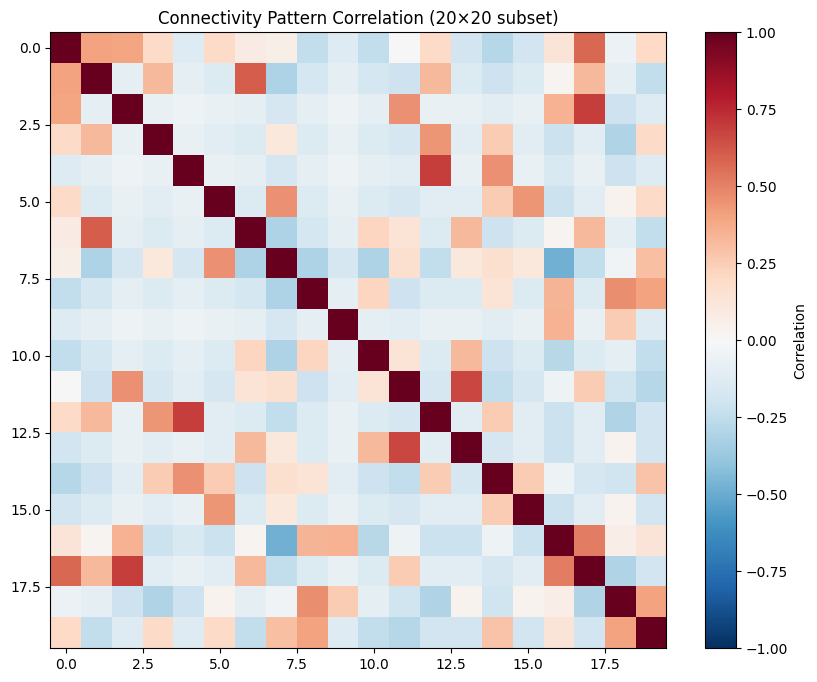


This shows correlations between neurons' connectivity patterns.
High correlation means neurons have similar connection patterns.


In [23]:
# Create a network with some structure
conn_struct = conn.Random(prob=0.15, seed=42)
result_struct = conn_struct(pre_size=50, post_size=50)

# Create connectivity matrix
conn_mat = result_to_matrix(result_struct)

# Sample subset for visualization clarity
subset_size = 20
conn_subset = conn_mat[:subset_size, :subset_size]

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
vis.correlation_matrix(
    conn_subset,
    method='pearson',
    cmap='RdBu_r',
    show_values=False,
    ax=ax,
    title='Connectivity Pattern Correlation (20×20 subset)'
)
plt.show()

print("\nThis shows correlations between neurons' connectivity patterns.")
print("High correlation means neurons have similar connection patterns.")

---

## 7. Exercises <a name="exercises"></a>

Try these exercises to reinforce your understanding:

### Exercise 1: Connection Probability Calibration

Create a function that finds the connection probability needed to achieve a target number of connections:

In [ ]:
def find_target_probability(pre_size, post_size, target_connections, tolerance=50, max_iterations=20):
    """
    Find connection probability to achieve target number of connections.
    
    Parameters
    ----------
    pre_size : int
        Number of presynaptic neurons
    post_size : int
        Number of postsynaptic neurons
    target_connections : int
        Desired number of connections
    tolerance : int
        Acceptable deviation from target
    max_iterations : int
        Maximum search iterations
    
    Returns
    -------
    prob : float
        Connection probability
    actual : int
        Actual connections achieved
    """
    # YOUR CODE HERE
    # Hint: Use binary search or gradient descent approach
    # Start with initial probability estimate: target_connections / (pre_size * post_size)
    
    pass

# Test your function
# prob, actual = find_target_probability(pre_size=100, post_size=100, target_connections=1000)
# print(f"Target: 1000 connections")
# print(f"Probability: {prob:.4f}")
# print(f"Actual: {actual} connections")

### Exercise 2: Weight Scaling

Create a custom weight initialization that scales weights inversely with the number of incoming connections (to maintain constant total input):

In [ ]:
def create_scaled_weights(result, base_weight=1.0 * u.nS):
    """
    Scale weights inversely with in-degree to maintain constant total input.
    
    Parameters
    ----------
    result : ConnectionResult
        Connectivity result
    base_weight : Quantity
        Base weight value
    
    Returns
    -------
    scaled_weights : array
        Scaled weight array
    """
    # YOUR CODE HERE
    # Hint: Calculate in-degree for each post neuron
    # Then scale weights: w_scaled = base_weight / in_degree
    
    pass

# Test your function
# conn_test = conn.Random(prob=0.1, seed=42)
# result_test = conn_test(pre_size=100, post_size=100)
# scaled_weights = create_scaled_weights(result_test, base_weight=1.0 * u.nS)
# 
# # Verify constant total input
# post_size = 100
# total_inputs = np.zeros(post_size)
# for post_idx in range(post_size):
#     mask = result_test.post_indices == post_idx
#     total_inputs[post_idx] = np.sum(u.get_mantissa(scaled_weights[mask]))
# 
# print(f"Total input per neuron - Mean: {np.mean(total_inputs):.3f}, Std: {np.std(total_inputs):.3f}")

### Exercise 3: Connectivity Statistics

Write a function that computes comprehensive connectivity statistics:

In [ ]:
def analyze_connectivity(result):
    """
    Compute comprehensive connectivity statistics.
    
    Should calculate:
    - Connection density
    - Mean/std of in-degree and out-degree
    - Weight statistics (if present)
    - Delay statistics (if present)
    - Reciprocal connections (if pre_size == post_size)
    
    Returns
    -------
    stats : dict
        Dictionary of statistics
    """
    # YOUR CODE HERE
    
    pass

# Test your function
# conn_test = conn.Random(prob=0.15, weight=Normal(mean=1.0*u.nS, std=0.2*u.nS), seed=42)
# result_test = conn_test(pre_size=100, post_size=100)
# stats = analyze_connectivity(result_test)
# 
# for key, value in stats.items():
#     print(f"{key}: {value}")